In [28]:
%pylab inline
from IPython.display import Image
import pydotplus

from gplearn.genetic import SymbolicRegressor
from gplearn.fitness import make_fitness
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

data_m = []
data_b = []
for input, output in zip(data["data"],data['target']):
    if output == 0:
        data_m.append((input,output))
    else:
        data_b.append((input,output))
data["data"].shape

Populating the interactive namespace from numpy and matplotlib


(569, 30)

<p><strong>Data Wrangling</strong></p>
<p>Here we seperate the data out into 100 training cases, equal parts malaginint and benign, and 469 remaining evalulation cases.</p>

In [18]:
#variable to store number of values to train off of, selected at a 50/50 mix
num_train = 100

train_x = []
train_y = []

eval_x = []
eval_y = []

#populate the training data
for i in range(0,num_train//2):
    train_x.append(data_m[i][0])
    train_x.append(data_b[i][0])
    train_y.append(data_m[i][1])
    train_y.append(data_b[i][1])
    
for item in data_m[num_train//2:]:
    eval_x.append(item[0])
    eval_y.append(item[1])

for item in data_b[num_train//2:]:
    eval_x.append(item[0])
    eval_y.append(item[1])
train_x = numpy.stack(train_x)
train_y = np.array(train_y)

In [20]:
#fittness function
#if an output is greater then 0, it's counted as a 1 "benign", if it's less than, its malignant
def _custom_fitness(y, y_pred, w):
    diffs = (y_pred >=0) != y
    return float(np.sum(diffs))
custom_fitness = make_fitness(_custom_fitness, greater_is_better=False)

<p><strong>Symbolic regression</strong></p>
<p> We run a symbolic regression on a 1000 individuals for 20 generations. There are three kinds of mutation, subtree, hoist, and point. The hoist mutation is the only type that differs significantly from what was talked about in class. In it, a random subtree is selected, then, a random subtree from within it is lifted to it’s root node. It is used to combat tree bloat, and it appears to be very effective. Without the hoist mutation, tree trees grew like redwoods. <p>


In [21]:
best_gp = SymbolicRegressor(population_size=1000,
                           generations=20, stopping_criteria=1,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=1.0, verbose=1,
                           parsimony_coefficient=0.001, random_state=0,
                           metric = custom_fitness)
best_gp.fit(train_x, train_y)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.57           50.417      127             14.0              N/A      7.62s
   1    56.15           44.023       61             11.0              N/A     22.87s
   2    88.07           34.808       55              7.0              N/A     27.18s
   3     99.6           28.612       67              7.0              N/A     28.48s
   4    66.49           27.559       83              5.0              N/A     27.75s
   5    58.74           25.444       63              4.0              N/A     27.29s
   6    51.83           25.535       59              3.0              N/A     25.83s
   7    58.77           23.256       61              3.0              N/A     23.79s
   8    56.59           23.015      127              3.0              N/A  

SymbolicRegressor(const_range=(-1.0, 1.0),
         function_set=('add', 'sub', 'mul', 'div'), generations=20,
         init_depth=(2, 6), init_method='half and half', max_samples=1.0,
         metric=<gplearn.fitness._Fitness object at 0x00000186F220CF60>,
         n_jobs=1, p_crossover=0.7, p_hoist_mutation=0.05,
         p_point_mutation=0.1, p_point_replace=0.05,
         p_subtree_mutation=0.1, parsimony_coefficient=0.001,
         population_size=1000, random_state=0, stopping_criteria=1,
         tournament_size=20, verbose=1, warm_start=False)

In [22]:
print(best_gp._program)

sub(add(add(div(sub(X3, X4), mul(X13, X24)), sub(div(sub(X3, X4), mul(X13, X24)), sub(X2, X22))), div(div(sub(X19, X12), div(X19, X24)), mul(div(X21, X3), div(sub(X13, sub(X26, X23)), mul(X13, X24))))), mul(sub(div(X26, X28), sub(X2, X22)), add(sub(add(X21, X9), div(X10, X7)), X5)))


In [23]:
score_gp = best_gp.predict(eval_x)
pred_eval_y = score_gp >= 0
diffs = pred_eval_y != eval_y
num_wrong =np.sum(diffs)

In [24]:
#number of values the gp got wrong in the training set
print(num_wrong)

38


<p><strong>Best performing tree</strong></p>


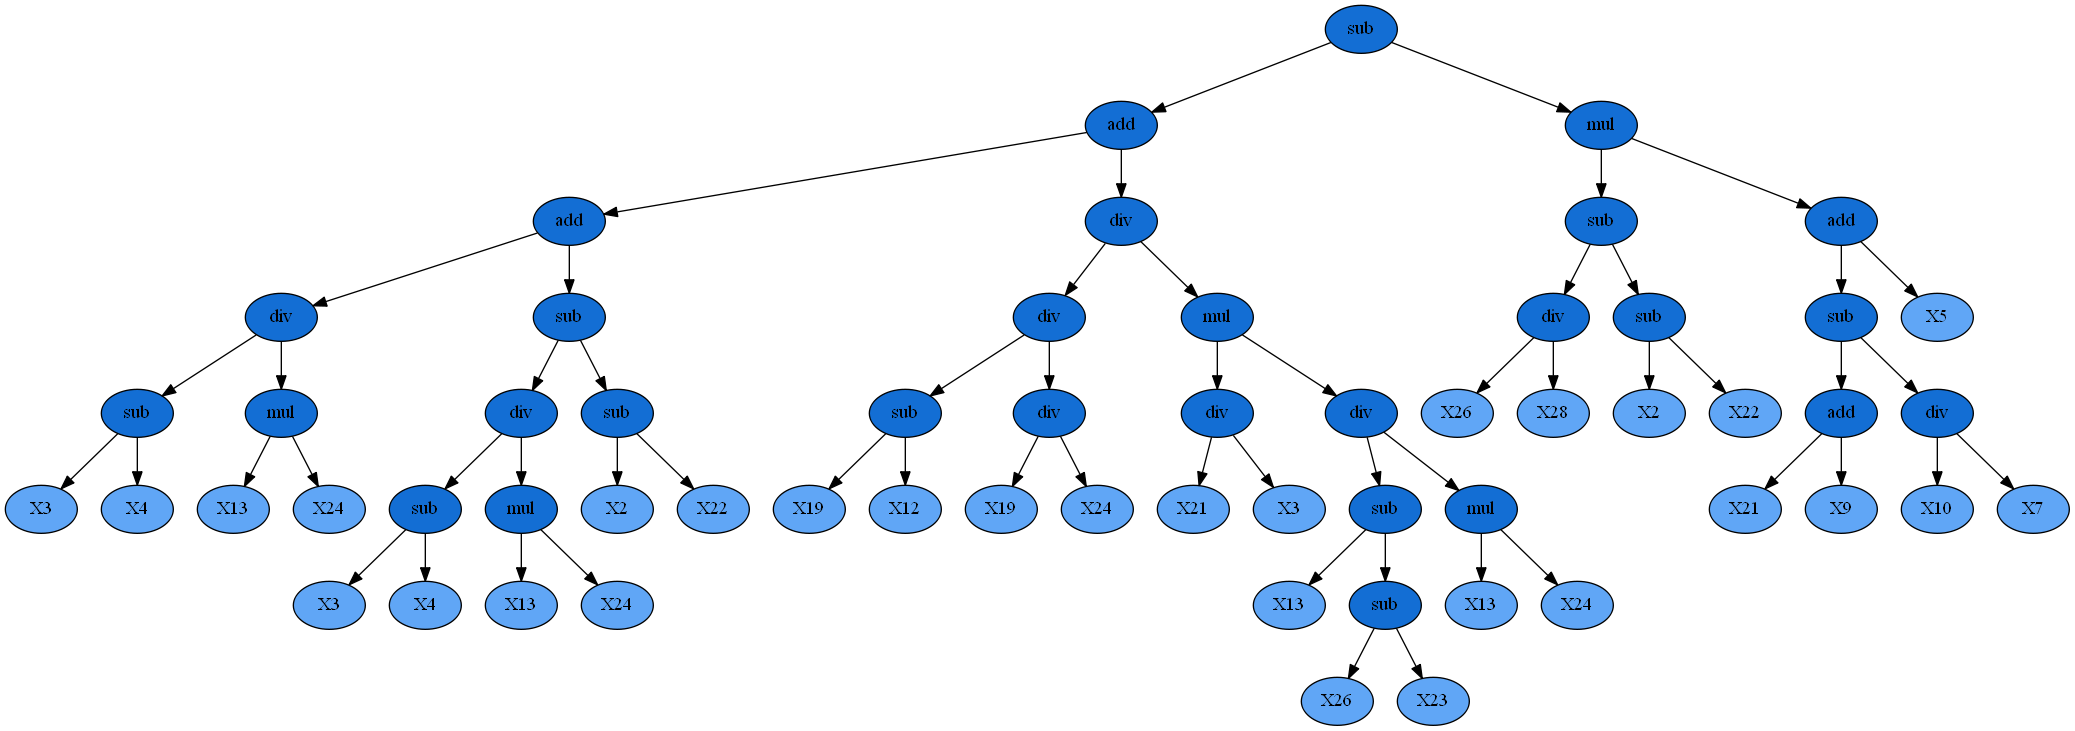

In [29]:
graph = pydotplus.graphviz.graph_from_dot_data(est_gp._program.export_graphviz())
Image(graph.create_png())